Copyright (C) 2024  Adam Jones  All Rights Reserved

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.

You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

In [1]:
import warnings

import figure_standard
import pandas as pd
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import os

In [2]:
figure_standard.standardize_plot_settings()
main_palette = figure_standard.create_main_palette()

In [3]:
# get the meta results (including comparisons)
df_meta_results = pd.read_csv("../1_meta_analysis/meta_results_lci.csv")

In [4]:
# also, get the input so the weights can be calculated
# and the CIs can be plotted
df_meta_input = pd.read_excel("../1_meta_analysis/meta_input.xlsx")

# drop the excluded ones
df_meta_input.drop(df_meta_input[df_meta_input.exclude == 1.0].index, inplace=True)
df_meta_input.drop(df_meta_input[df_meta_input.paper == "Jones"].index, inplace=True)

# for null se values, where std is known, use that
use_std_indexes = df_meta_input[
    df_meta_input.se.isnull() & ~df_meta_input["std"].isnull()
].index
df_meta_input.loc[use_std_indexes, "se"] = df_meta_input.loc[use_std_indexes].apply(
    lambda x: x["std"] / math.sqrt(x["n"]), axis=1
)

# # for null se values, were CIs are known, use them
use_cis_indexes = df_meta_input[
    df_meta_input.se.isnull() & ~df_meta_input["lower_ci"].isnull()
].index
df_meta_input.loc[use_cis_indexes, "se"] = df_meta_input.loc[use_cis_indexes].apply(
    lambda x: (x["upper_ci"] - x["lower_ci"]) / 3.919928, axis=1
)

# # should be no more remaining unknown se values
assert df_meta_input.se.isnull().sum() == 0

# nor remaining null std values, calculate them using se
calc_std_indexes = df_meta_input[df_meta_input["std"].isnull()].index
df_meta_input.loc[calc_std_indexes, "std"] = df_meta_input.loc[calc_std_indexes].apply(
    lambda x: x["se"] * math.sqrt(x["n"]), axis=1
)

# should be no more remaining unknown std values
assert df_meta_input["std"].isnull().sum() == 0

# calculate missing CIs
calc_cis_indexes = df_meta_input[df_meta_input["lower_ci"].isnull()].index
df_meta_input.loc[calc_cis_indexes, "lower_ci"] = df_meta_input.loc[
    calc_cis_indexes
].apply(lambda x: x["kappa"] - x["se"] * 3.919928 / 2, axis=1)
df_meta_input.loc[calc_cis_indexes, "upper_ci"] = df_meta_input.loc[
    calc_cis_indexes
].apply(lambda x: x["kappa"] + x["se"] * 3.919928 / 2, axis=1)

In [5]:
stages = ["All", "Wake", "N1", "N2", "N3", "REM"]
studies = ["All", "CCSHS", "CFS", "CHAT", "MESA", "WSC"]

# reset the weights
df_meta_input["weight"] = 0

# now, using the tau2h value from the results, calculate the weights
for stage in stages:

    weight_indexes = df_meta_input.loc[df_meta_input.stage == stage].index

    # calculate the weight for each w=(se^2+tau^2)^-1
    w = (
        df_meta_input.loc[weight_indexes].se.values ** 2
        + df_meta_results.loc[df_meta_results.stage == stage].tau2h.values
    ) ** -1
    # normalize the weights so that the sum is 1
    w = w / w.sum()

    df_meta_input.loc[weight_indexes, "weight"] = w

1 extra bytes in post.stringData array
fdsc NOT subset; don't know how to subset; dropped
fond NOT subset; don't know how to subset; dropped
just NOT subset; don't know how to subset; dropped


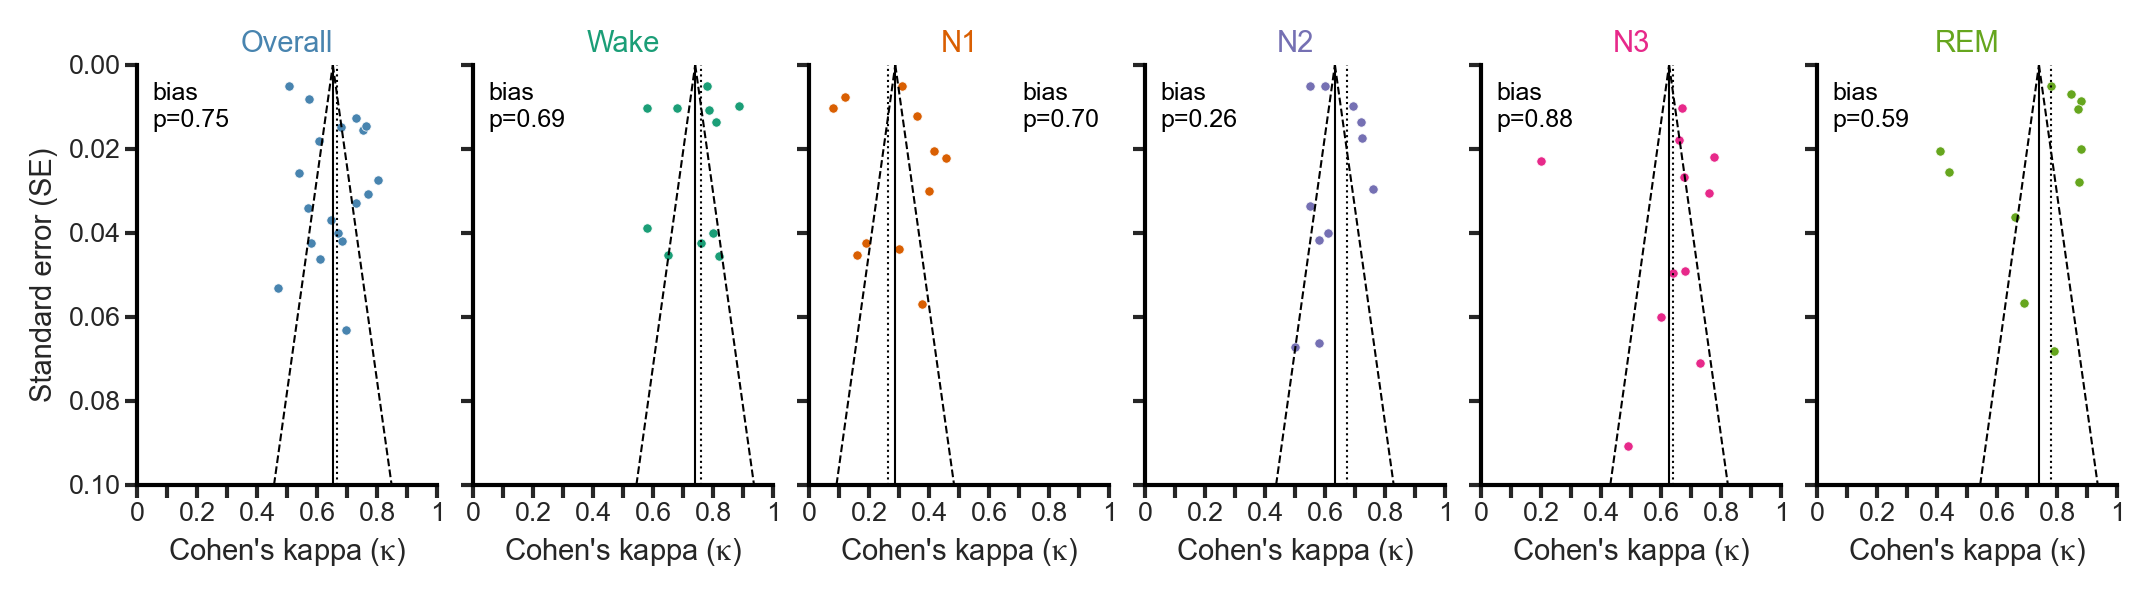

In [6]:
y_max_value = 0.1
alpha = 0.05
ci_line_width = 0.5


gs = gridspec.GridSpec(1, 6)
ax = []

for i, stage in enumerate(stages):
    ax += [plt.subplot(gs[0, i])]

    mean_effect = df_meta_results.loc[df_meta_results.stage == stage, "mean"].values[0]

    sns.scatterplot(
        x=df_meta_input.loc[df_meta_input.stage == stage, "kappa"],
        y=df_meta_input.loc[df_meta_input.stage == stage, "se"],
        color=main_palette[i],
        ax=ax[i],
        s=5,
    )

    ci_line_y = np.array([0, y_max_value])

    
    k = 3.919928 / 2

    ci_line_x_lower = mean_effect - k * ci_line_y
    ci_line_x_upper = mean_effect + k * ci_line_y
    sns.lineplot(
        x=ci_line_x_lower,
        y=ci_line_y,
        ax=ax[i],
        color="black",
        linewidth=ci_line_width,
        linestyle="dashed",
    )
    sns.lineplot(
        x=ci_line_x_upper,
        y=ci_line_y,
        ax=ax[i],
        color="black",
        linewidth=ci_line_width,
        linestyle="dashed",
    )
    ax[i].axvline(
        x=mean_effect,
        ymin=0,
        ymax=1,
        color="black",
        linewidth=ci_line_width,
    )

    bias_mean = df_meta_results.loc[df_meta_results.stage == stage, "bias_mean"].values[
        0
    ]
    ax[i].axvline(
        x=bias_mean,
        ymin=0,
        ymax=1,
        color="black",
        linewidth=ci_line_width,
        linestyle="dotted",
    )

    ax[i].set_ylim([0, y_max_value])
    ax[i].invert_yaxis()

    labelpad = 2.5
    ax[i].set_xlabel("Cohen's kappa ($\kappa$)", fontweight=None, labelpad=labelpad)
    if i == 0:
        ax[i].set_ylabel("Standard error (SE)", fontweight=None, labelpad=labelpad)

    else:
        for label in ax[i].get_yticklabels():
            label.set_visible(False)
        ax[i].set_ylabel("", fontweight=None, labelpad=labelpad)

    sns.despine(ax=ax[i], right=True, top=True, bottom=False)
    ax[i].grid(False)
    ax[i].tick_params(axis="y", left=True, width=1, length=3, pad=1)
    ax[i].tick_params(axis="x", bottom=True, width=1, length=3, pad=1)

    ax[i].set_xlim([0, 1])
    ax[i].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    # remove decimal points for first and last tick label
    labels = ax[i].get_xticklabels()
    labels[0] = str(0)
    labels[-1] = str(1)
    labels
    ax[i].set_xticklabels(labels)

    for label in ax[i].get_xticklabels()[1::2]:
        label.set_visible(False)

    title_fontsize = 7
    title_y = 1.05

    if stage == "All":
        stage_title = "Overall"
    else:
        stage_title = stage
    ax[i].text(
        0.5,
        title_y,
        stage_title,
        transform=ax[i].transAxes,
        color=main_palette[i],
        fontsize=title_fontsize,
        va="center",
        ha="center",
    )

    bias_p = df_meta_results.loc[df_meta_results.stage == stage, "bias_p"].values[0]
    if i != 2:
        x_loc = 0.05
        ha = "left"
    else:
        x_loc = 0.71
        ha = "left"
    ax[i].text(
        x_loc,
        0.90,
        f"bias\np={bias_p:#.02g}",
        transform=ax[i].transAxes,
        color="black",
        fontsize=6,
        va="center",
        ha=ha,
    )


plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.12)
figure_standard.scale_figure_by_axes(ax[0], 1.4, 1)

# save the figure
filename = os.path.basename(globals()["__vsc_ipynb_file__"]).replace(".ipynb", "")
figure_standard.save_figure_files(filename)